# Ideal Parameter Analysis ($\delta=1.25$, $\tau=1.25$, $\alpha=2$) ($\delta$ very low)

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sys

from datetime import datetime

sys.path.append('../../feeg_fmri_sync')

from feeg_fmri_sync.plotting import (
    plot_all_search_results_2d,
    plot_local_minima
)
from feeg_fmri_sync.search import (
    build_models,
    search_voxels
)
from feeg_fmri_sync.simulations import (
    build_model_to_fmri,
    generate_downsampled_simulated_fmri,
)
from feeg_fmri_sync.utils import (
    generate_descriptions_from_search_df,
)
from feeg_fmri_sync.vectorized_models import VectorizedHemodynamicModel

In [2]:
try_to_reuse = True
submit_to_cluster = False

## Initialize constants for Hemodynamic Modeling

In [3]:
### Initialize constants ###
sample_freq = 20
tr = 800
n_trs_skipped_at_beginning = 0
hemodynamic_response_window = 30

# Actual Values to generate data from
expected_delta = 1.25
expected_tau=1.25
expected_alpha=2

## Initialize constants for simulation

In [4]:
# Plot the generated data
# NOTE: only the first of the trials will be plotted
plot_generated_data = True

# Plot perfect data when modeling
plot_perfect_comparison = True

# noises to examine and plot when modeling
noise_range = range(1, 11)  
noises_to_plot = [3, 5, 10]

# trials we run for each condition and how many trials to plot when modeling
num_trials = 100  
num_trials_to_plot = 1

# models to examine
models_to_test = [
    {
        'name': 'downsample',
        'model': VectorizedHemodynamicModel,
        'fmri_data_generator': generate_downsampled_simulated_fmri,
    }
]

# eeg data types to use
eeg_data_options_for_fmri_generation = ['without_nans']
eeg_data_options_for_simulation = ['without_nans', 'with_nans']

## Display Generated Noise against Simulated Ground Truth

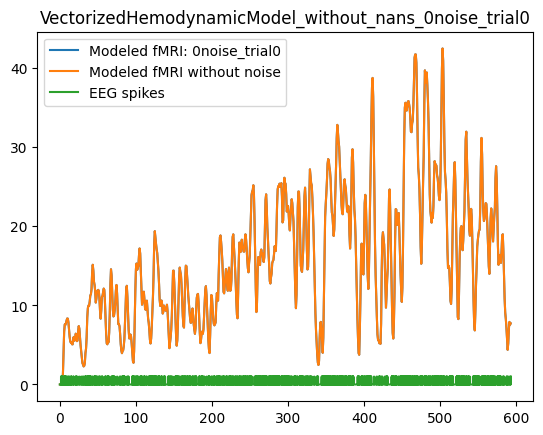

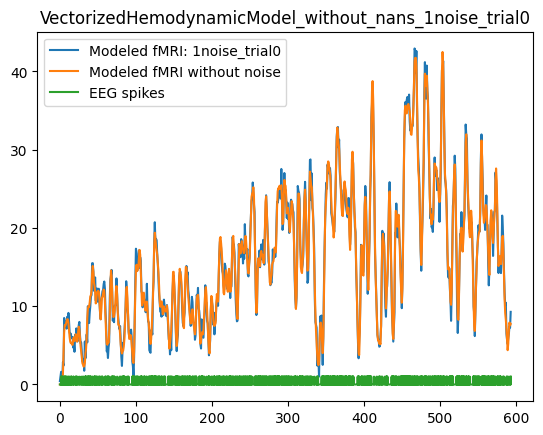

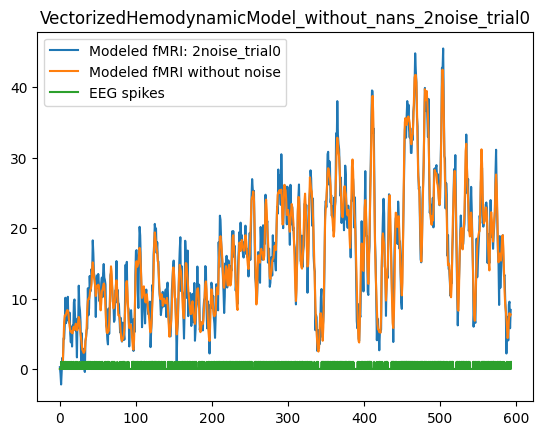

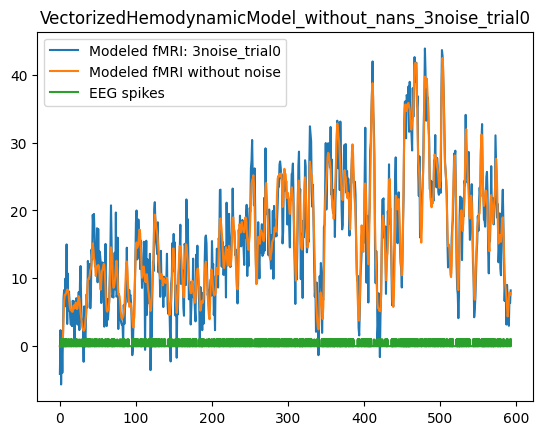

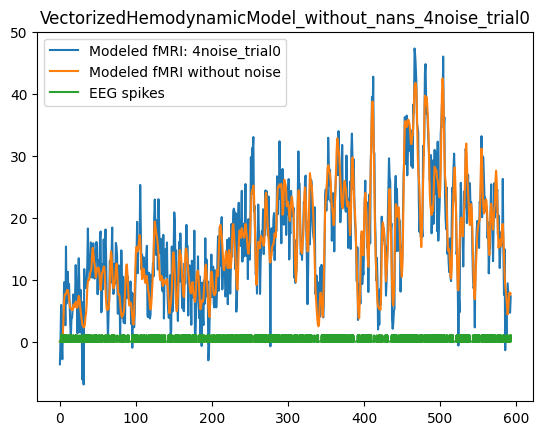

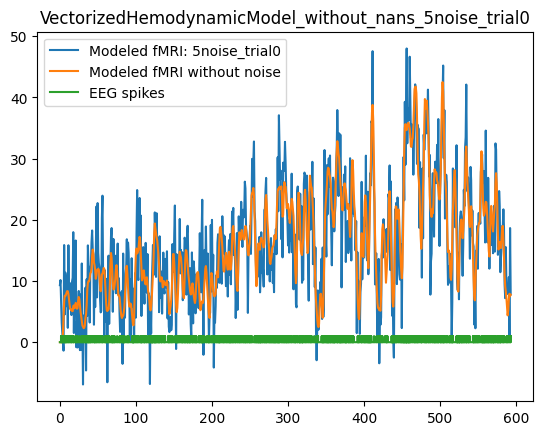

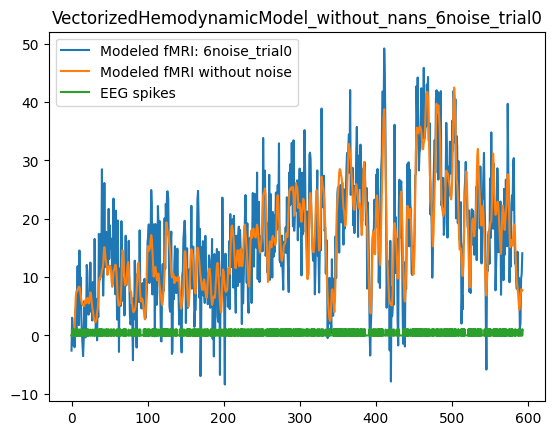

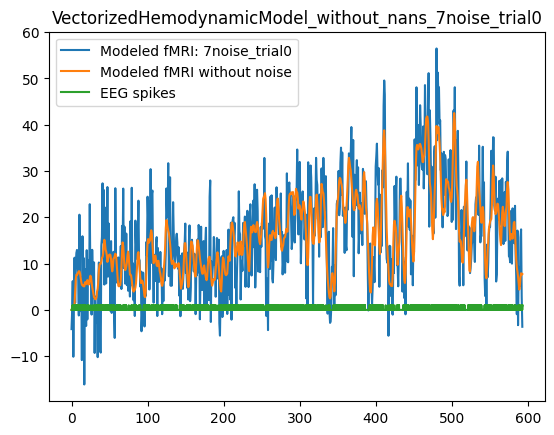

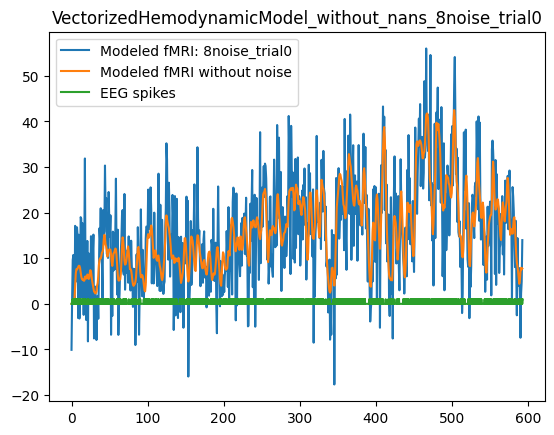

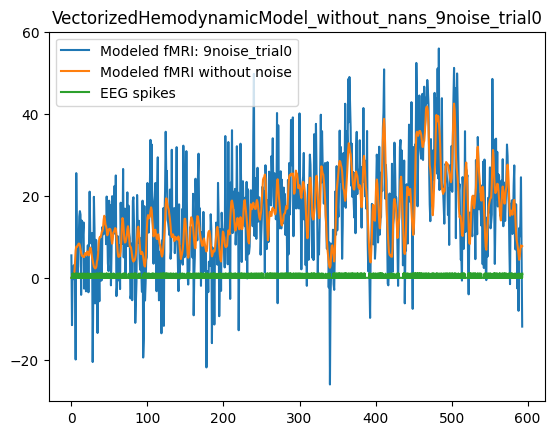

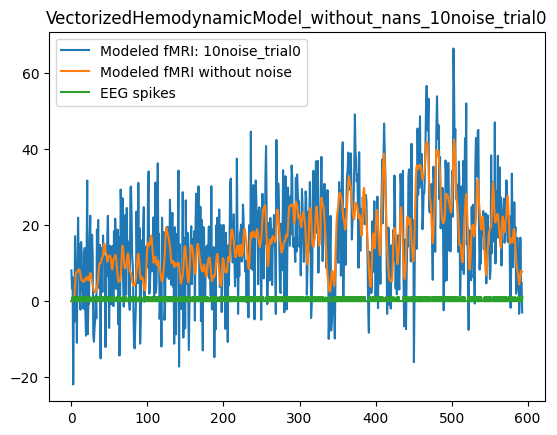

In [5]:
# Generate fMRI data
model_to_fmri = build_model_to_fmri(
    models_to_test,
    eeg_data_options_for_fmri_generation,
    expected_delta,
    expected_tau,
    expected_alpha,
    num_trials,
    num_trials_to_plot,
    noise_range,
    noises_to_plot,
    plot_perfect_comparison,
    tr,
    sample_freq,
    hemodynamic_response_window,
    plot_generated_data
)


## Initialize Analysis variables

In [6]:
step_size = 0.05

filename_substring = f'effect_of_ideal_params_delta{expected_delta}_tau{expected_tau}_alpha{expected_alpha}'
filename_ext = '.csv'
plot = True

delta = np.arange(1, 3+step_size, step_size)
tau = np.arange(0.75, 1.75+step_size, step_size)
alpha = np.arange(1.75, 2.25+step_size, step_size)

print(f'Delta target: {expected_delta}, Range:\n{delta}\n')
print(f'Tau target: {expected_tau}, Range:\n{tau}\n')
print(f'Alpha target: {expected_alpha}, Range:\n{alpha}\n')

Delta target: 1.25, Range:
[1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65
 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35
 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.  ]

Tau target: 1.25, Range:
[0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75]

Alpha target: 2, Range:
[1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25]



## Est vs Actual for all models at correct points

Scoring downsample_without_nans_without_nans delta=1.25, tau=1.25, alpha=2


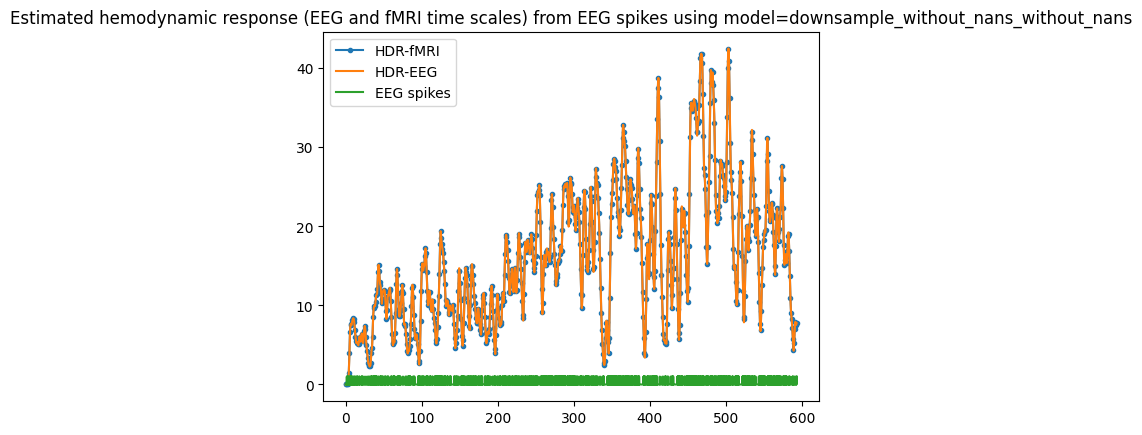

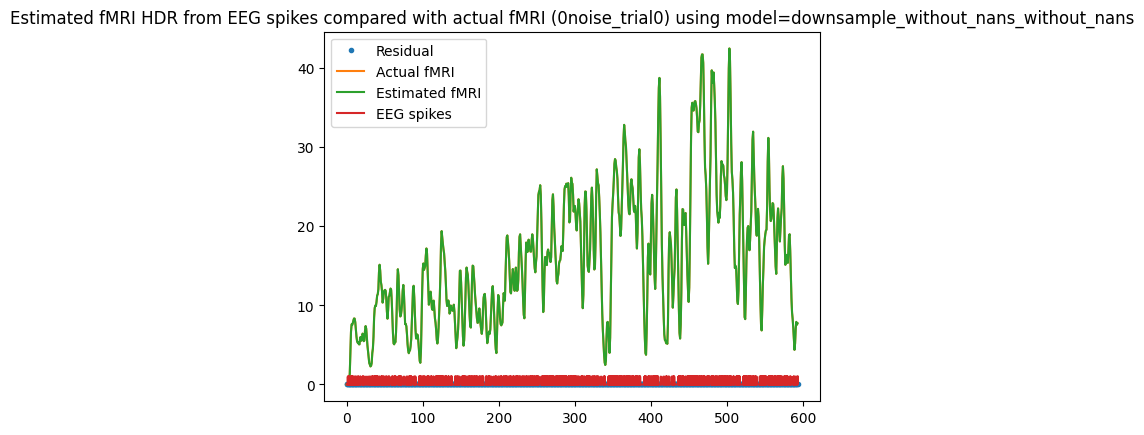

Residual Variance is 0.000000


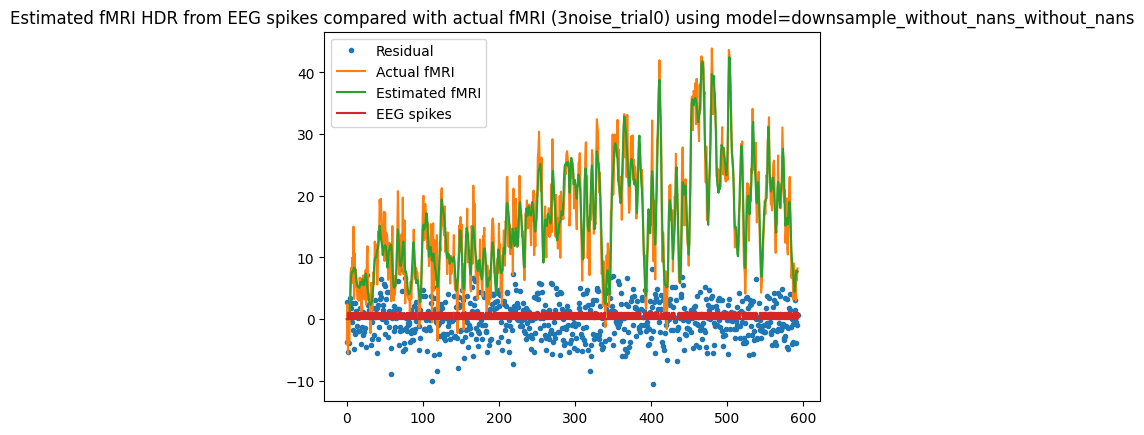

Residual Variance is 9.572820


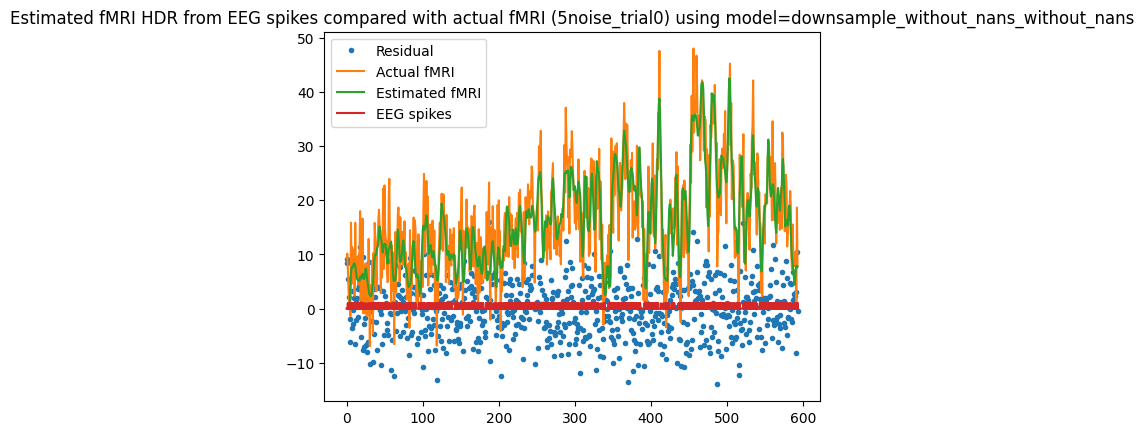

Residual Variance is 26.223626


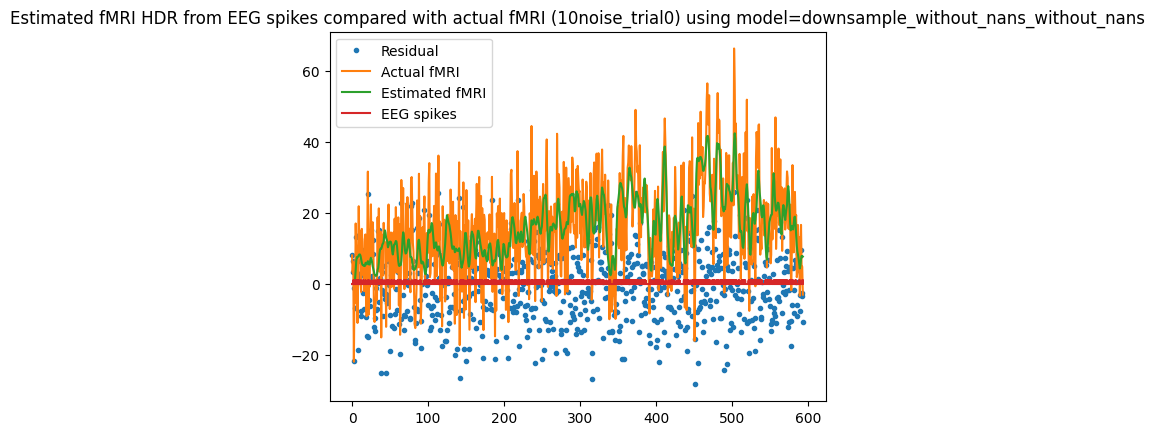

Residual Variance is 107.446873


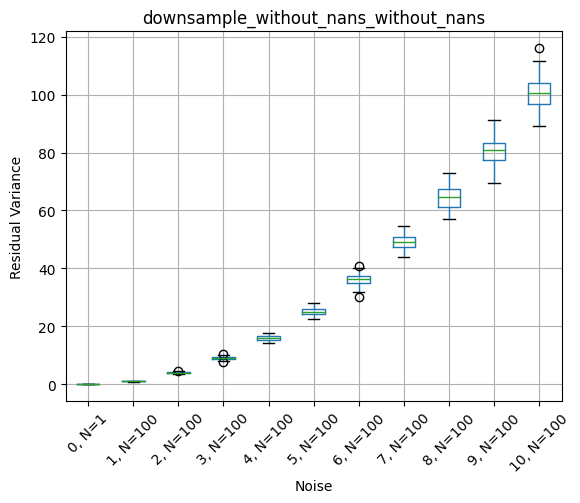

Scoring downsample_without_nans_with_nans delta=1.25, tau=1.25, alpha=2


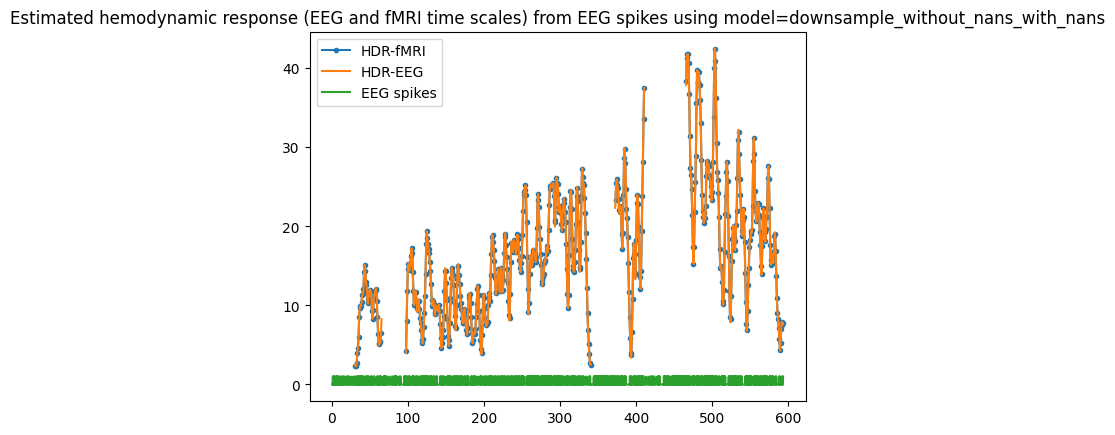

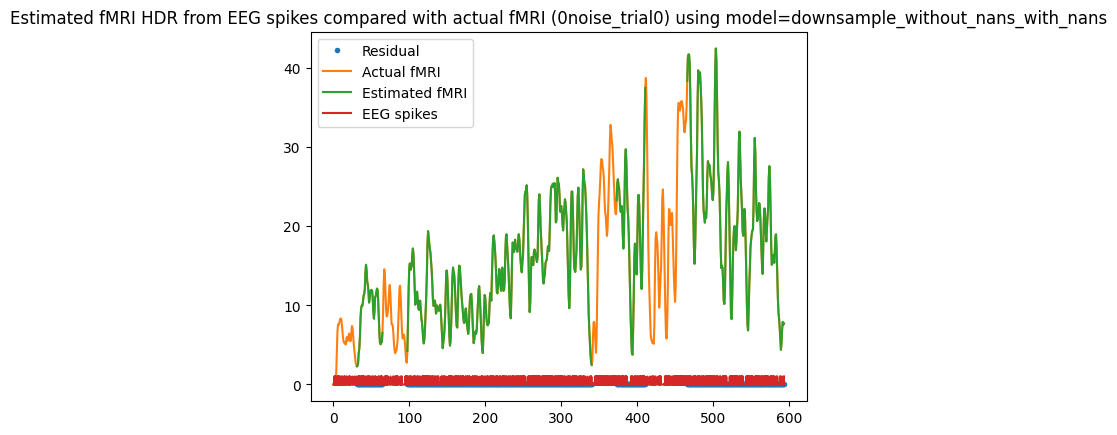

Residual Variance is 0.000000


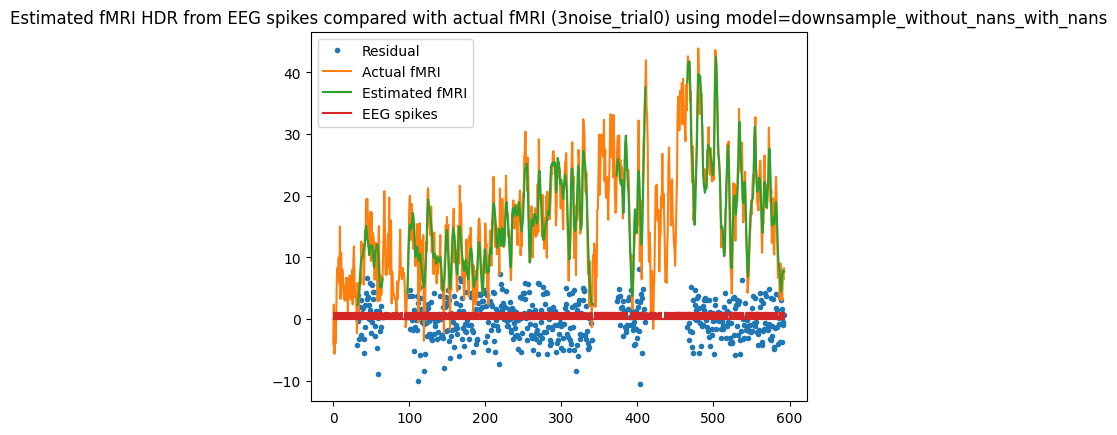

Residual Variance is 9.433621


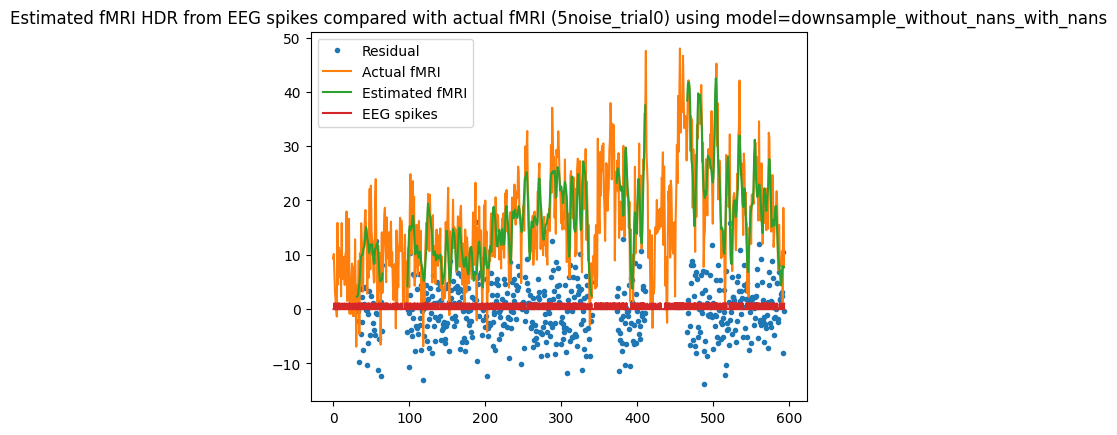

Residual Variance is 25.292046


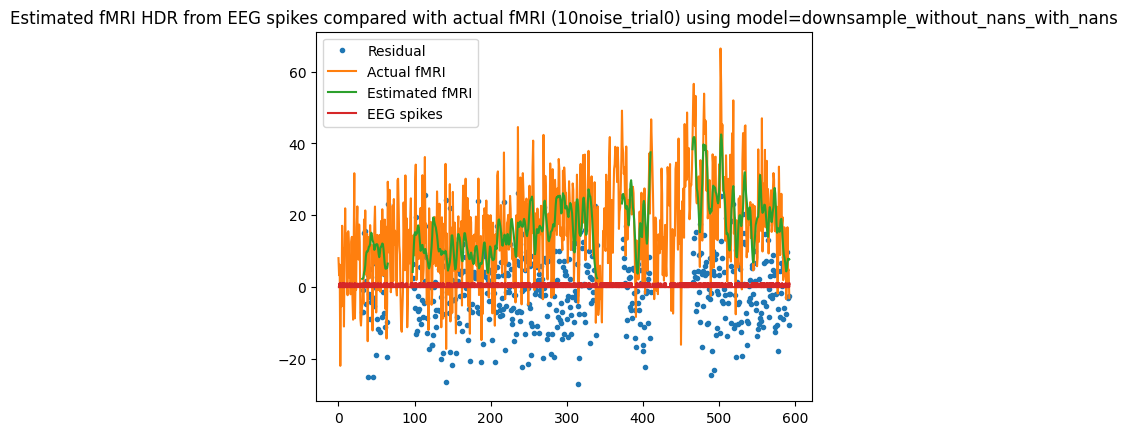

Residual Variance is 106.645735


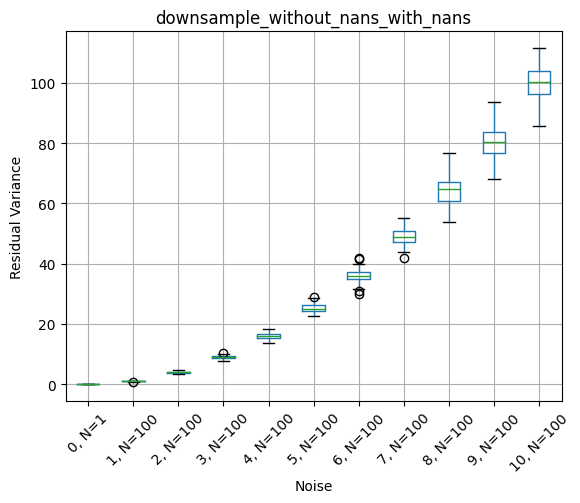

In [7]:
models = build_models(
    model_to_fmri,
    eeg_data_options_for_simulation,
    tr, 
    n_trs_skipped_at_beginning,
    sample_freq,
    hemodynamic_response_window,
    plot
)

# Get in-depth plots for actual delta, tau, alpha
for model_name, model in models.items():
    residual_var = model.score(expected_delta, expected_tau, expected_alpha)
    fmri_names = np.array(model.fmri.voxel_names)
    if (fmri_names == None).any():
        print(f'Residual variance was {residual_var}')
    else:
        noise_levels = np.char.replace(fmri_names, 'perfect', '0noise_trail0')
        noise_levels = np.char.partition(noise_levels, sep='noise')
        res_var_df = pd.DataFrame(zip(noise_levels[:,0].astype(int), residual_var), columns=['Noise', 'res_var'])
        res_var_by_noise = res_var_df.groupby('Noise')
        _, axs = plt.subplots()
        axs.set_title(model_name)
        axs.set_ylabel('Residual Variance')
        axs.set_xlabel('Noise')
        axs = res_var_by_noise.boxplot(column='res_var', subplots=False, rot=45, ax=axs)
        labels = res_var_by_noise.count()
        labels = [f'{noise}, N={n.item()}' for noise, n in zip(labels.index, labels.values)]
        plt.setp(axs, xticklabels=labels)
        plt.show()
    model.plot = False

## Generate/Load the full dataset

In [8]:
# Optional Reuse functionality

df = pd.DataFrame()
descriptions = []

if try_to_reuse:
    matching_files = sorted(glob.glob(f'{filename_substring}*{filename_ext}'))
    filename_to_use = "none"
    if len(matching_files) != 0:
        filename_to_use = input(
            f'Found previously run data. Enter name to reuse or "none" to recalculate.'
            f'\n{matching_files}\nDefault ({matching_files[-1]})\n'
        )
    if filename_to_use.lower() != "none":
        if filename_to_use.strip() == '':
            filename_to_use = matching_files[-1]
        print(f'Loading data from {filename_to_use}...')
        with open(filename_to_use, 'r') as f:
            df = pd.read_csv(f, index_col=0)
        descriptions = generate_descriptions_from_search_df(df, models)


In [9]:
if df.empty:
    if submit_to_cluster:
        raise NotImplemented("Submitting to the cluster is not implemented!")
    print('Generating data!')
    descriptions, df = search_voxels(models, delta, tau, alpha)
    with open(f'{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
        pd.DataFrame(df).to_csv(f)
    for model_name, description in zip(models.keys(), descriptions):
        with open(f'{model_name}_summary_{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
            pd.DataFrame(description).transpose().to_csv(f)

df

Generating data!
Scoring delta=1.0
Scoring delta=1.05
Scoring delta=1.1
Scoring delta=1.1500000000000001
Scoring delta=1.2000000000000002
Scoring delta=1.2500000000000002
Scoring delta=1.3000000000000003
Scoring delta=1.3500000000000003
Scoring delta=1.4000000000000004
Scoring delta=1.4500000000000004
Scoring delta=1.5000000000000004
Scoring delta=1.5500000000000005
Scoring delta=1.6000000000000005
Scoring delta=1.6500000000000006
Scoring delta=1.7000000000000006
Scoring delta=1.7500000000000007
Scoring delta=1.8000000000000007
Scoring delta=1.8500000000000008
Scoring delta=1.9000000000000008
Scoring delta=1.9500000000000008
Scoring delta=2.000000000000001
Scoring delta=2.0500000000000007
Scoring delta=2.100000000000001
Scoring delta=2.1500000000000012
Scoring delta=2.200000000000001
Scoring delta=2.250000000000001
Scoring delta=2.300000000000001
Scoring delta=2.3500000000000014
Scoring delta=2.4000000000000012
Scoring delta=2.450000000000001
Scoring delta=2.5000000000000013
Scoring de

delta                 tau               alpha  \
0                     1.0                0.75                1.75   
1                     1.0                0.75                1.75   
2                     1.0                0.75                 1.8   
3                     1.0                0.75                 1.8   
4                     1.0                0.75                1.85   
...                   ...                 ...                 ...   
18937  3.0000000000000018  1.7500000000000009  2.1500000000000004   
18938  3.0000000000000018  1.7500000000000009                 2.2   
18939  3.0000000000000018  1.7500000000000009                 2.2   
18940  3.0000000000000018  1.7500000000000009  2.2500000000000004   
18941  3.0000000000000018  1.7500000000000009  2.2500000000000004   

                                 model_name       0noise_trial0  \
0      downsample_without_nans_without_nans  22.345868115363576   
1         downsample_without_nans_with_nans   20.74572253777622   
2      downsample_without_nans_without_nans  21.386773373615014   
3         downsample_without_nans_with_nans   19.86415202620161   
4      downsample_without_nans_without_nans   20.44406560999413   
...                                     ...                 ...   
18937     downsample_without_nans_with_nans  25.284952413328043   
18938  downsample_without_nans_without_nans   28.03930504311755   
18939     downsample_without_nans_with_nans  25.829045553972744   
18940  downsample_without_nans_without_nans   28.66857829378425   
18941     downsample_without_nans_with_nans  26.358691734322406   

            1noise_trial0       2noise_trial0       3noise_trial0  \
0       22.88028994497159   26.70430043330922  31.827713575161575   
1       21.60994616929925  25.335737620090516  31.108960711830303   
2       21.92307293012539   25.73214728236783  30.808280601347562   
3      20.722103412860385  24.434408243860137  30.165835021364014   
4      20.983190524272644  24.775900563234412    29.8064767121834   
...                   ...                 ...                 ...   
18937  26.796960908906776  29.865739350806148  37.611777611922925   
18938  29.484064207880106  32.640597565509275   41.05513469048659   
18939  27.342263474433828    30.4171966388263   38.18772006219367   
18940  30.110988358295685   33.28207894960046    41.7038034367673   
18941  27.873109224121066   30.95351169693048   38.74641876985312   

            4noise_trial0       5noise_trial0  ...      1noise_trial99  \
0       37.10471523047972  47.220543786793435  ...   23.25539245047041   
1       37.32082162453759   45.90694497881343  ...  21.826981774173852   
2        36.2411884767387  46.357163884532376  ...  22.281119151068367   
3       36.52274531524903   45.11047073766937  ...   20.92587137532283   
4      35.389849791137024   45.50801411283459  ...  21.323959063381796   
...                   ...                 ...  ...                 ...   
18937   39.92650883054746   46.74395322367409  ...  26.821788820206386   
18938   41.24649456707227   51.07802049804863  ...  29.512455899602017   
18939   40.46714303678265   47.28336965578517  ...   27.36985259170419   
18940   41.83588755460299   51.68773906061017  ...  30.140419371778027   
18941   40.99345099781883  47.810969254342204  ...   27.90309556013077   

           2noise_trial99      3noise_trial99      4noise_trial99  \
0      26.234906023545715   28.69060709665662    37.4255761911808   
1      24.651916772421405  28.316191758986122  35.372949964010125   
2      25.275200089633323   27.77908468116132   36.50030485312469   
3       23.75971861619538  27.426075294984095   34.52162453846597   
4       24.33181932946658  26.884840473424138  35.591505944248475   
...                   ...                 ...                 ...   
18937  30.545171819660993   34.89580263252939   42.16025828170416   
18938  32.627421412643926   36.06812310408104   44.26350163099656   
18939  31.098841351665573   35.44709960298005  

## No Noise Analysis - downsample without missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_without_nans) = 1.1533887657098978e-28; at
      delta   tau  alpha
2540   1.25  1.25    2.0


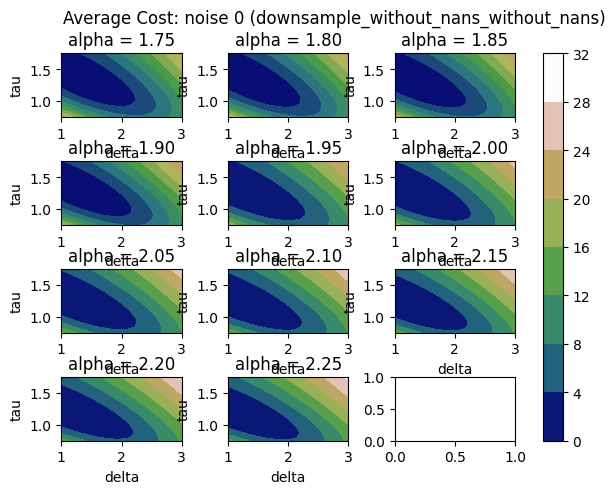

delta   tau  alpha  \
0        1.0  0.75   1.75   
2        1.0  0.75   1.80   
4        1.0  0.75   1.85   
6        1.0  0.75   1.90   
8        1.0  0.75   1.95   
...      ...   ...    ...   
18932    3.0  1.75   2.05   
18934    3.0  1.75   2.10   
18936    3.0  1.75   2.15   
18938    3.0  1.75   2.20   
18940    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_without_nans)  
0                                              22.345868             
2                                              21.386773             
4                                              20.444066             
6                                              19.518538             
8                                              18.610947             
...                                                  ...             
18932                                          26.069521             
18934                                          26.739481             
18936                                          27.396184             
18938                                          28.039305             
18940                                          28.668578             

[9471 rows x 4 columns]

In [10]:
model_name = 'downsample_without_nans_without_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [11]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 1.25, Tau target: 1.25, Alpha target: 2


delta   tau  alpha
0   1.25  1.25    2.0

### Local Minima Analysis

In [12]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 1.25, Tau target: 1.25, Alpha target: 2


noise iteration          cost  delta   tau  alpha
0      0         0  3.358920e-03   1.20  1.20   2.15
1      0         0  1.153389e-28   1.25  1.25   2.00
2      0         0  5.384653e-03   1.30  1.30   1.85

In [13]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [14]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [15]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [16]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [17]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [18]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [19]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## No Noise Analysis - downsample with missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_with_nans) = 3.1337856087800363e-28; at
      delta   tau  alpha
2541   1.25  1.25    2.0


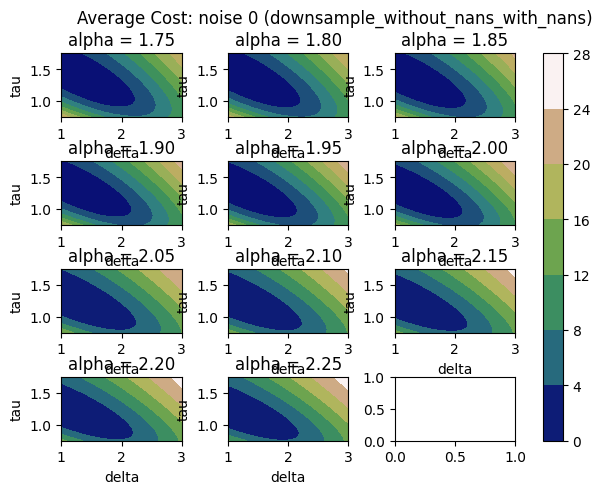

delta   tau  alpha  \
1        1.0  0.75   1.75   
3        1.0  0.75   1.80   
5        1.0  0.75   1.85   
7        1.0  0.75   1.90   
9        1.0  0.75   1.95   
...      ...   ...    ...   
18933    3.0  1.75   2.05   
18935    3.0  1.75   2.10   
18937    3.0  1.75   2.15   
18939    3.0  1.75   2.20   
18941    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_with_nans)  
1                                              20.745723          
3                                              19.864152          
5                                              18.996416          
7                                              18.143299          
9                                              17.305557          
...                                                  ...          
18933                                          24.154064          
18935                                          24.726557          
18937                                          25.284952          
18939                                          25.829046          
18941                                          26.358692          

[9471 rows x 4 columns]

In [20]:
model_name = 'downsample_without_nans_with_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [21]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 1.25, Tau target: 1.25, Alpha target: 2


delta   tau  alpha
0   1.25  1.25    2.0

### Local Minima Analysis

In [22]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 1.25, Tau target: 1.25, Alpha target: 2


noise iteration          cost  delta   tau  alpha
0      0         0  3.313385e-03   1.20  1.20   2.15
1      0         0  3.133786e-28   1.25  1.25   2.00
2      0         0  5.465230e-03   1.30  1.30   1.85

In [23]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [24]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [25]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [26]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [27]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [28]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [29]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## Cost by Noise

### Downsample without Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_without_nans) = 0.9986175815684216; at
      delta   tau  alpha
2540   1.25  1.25    2.0


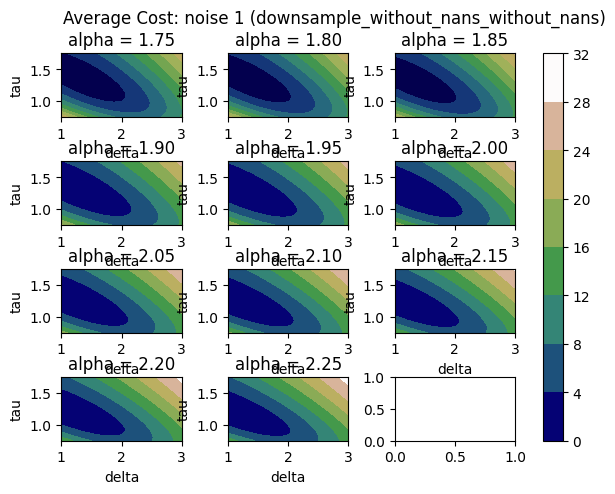

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_without_nans) = 4.00314303828159; at
      delta   tau  alpha
2540   1.25  1.25    2.0


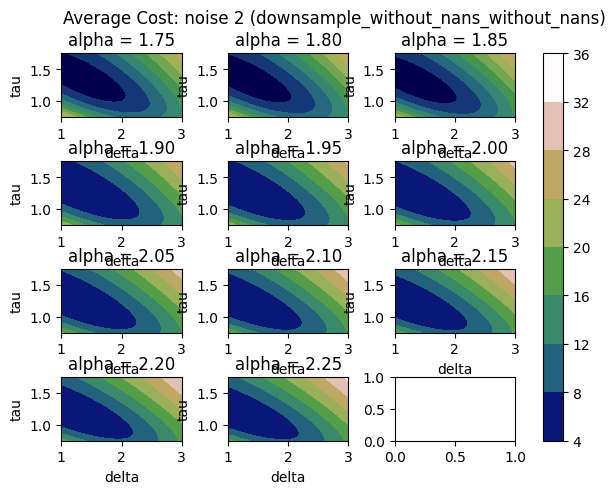

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_without_nans) = 8.961104602433306; at
      delta   tau  alpha
2540   1.25  1.25    2.0


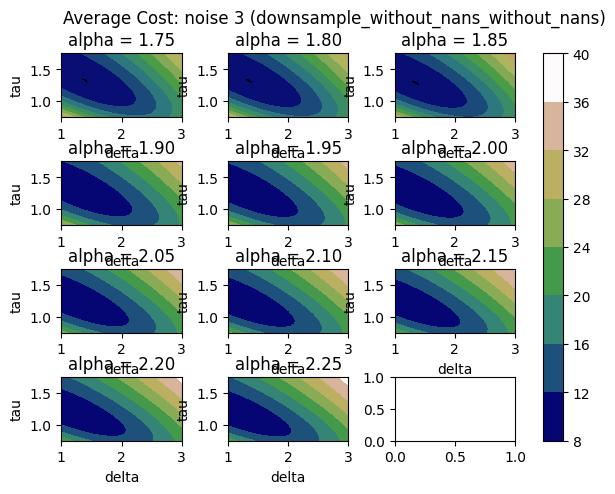

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_without_nans) = 15.988381182944158; at
      delta   tau  alpha
2540   1.25  1.25    2.0


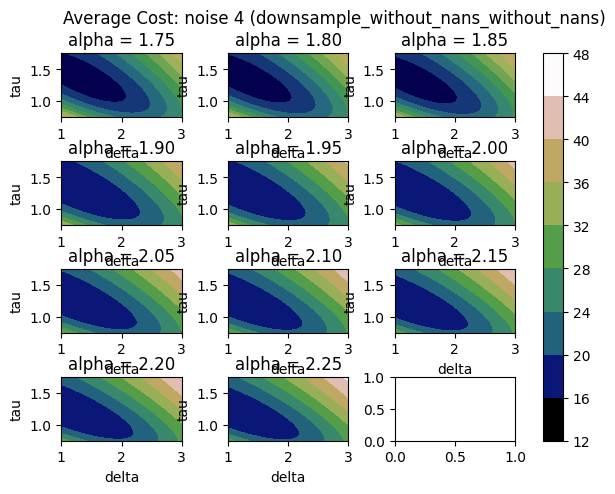

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_without_nans) = 25.117930370259042; at
      delta   tau  alpha
2540   1.25  1.25    2.0


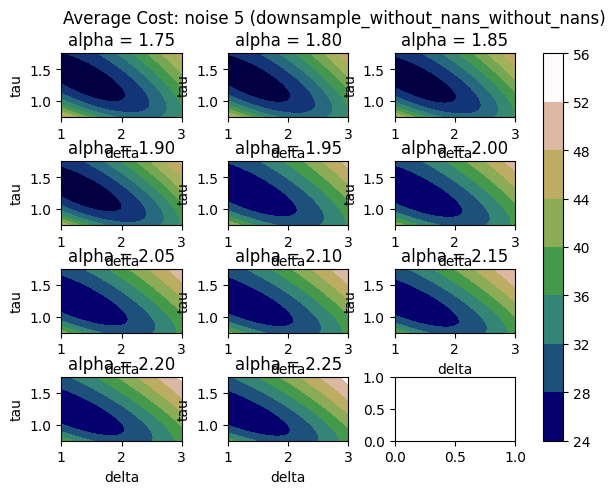

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_without_nans) = 36.114462598724096; at
      delta   tau  alpha
2540   1.25  1.25    2.0


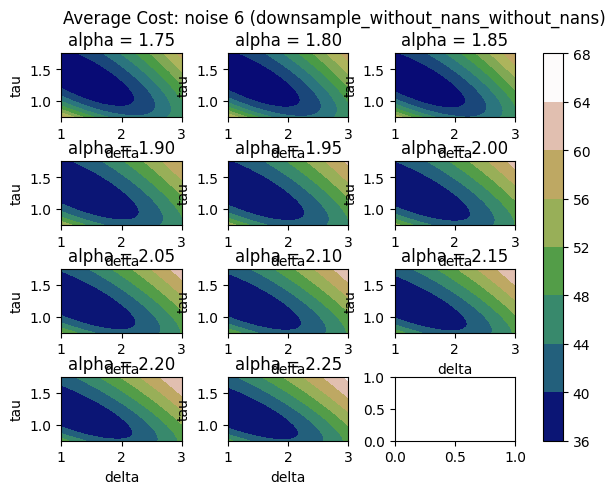

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_without_nans) = 49.07690608594174; at
      delta   tau  alpha
2540   1.25  1.25    2.0


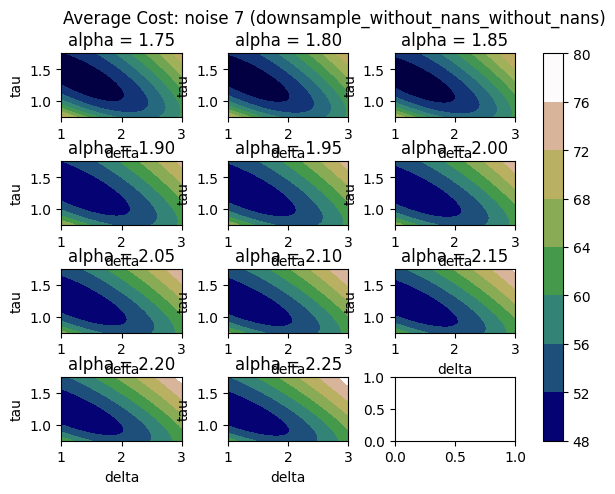

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_without_nans) = 64.28089998513121; at
      delta   tau  alpha
3000    1.3  1.25   1.95


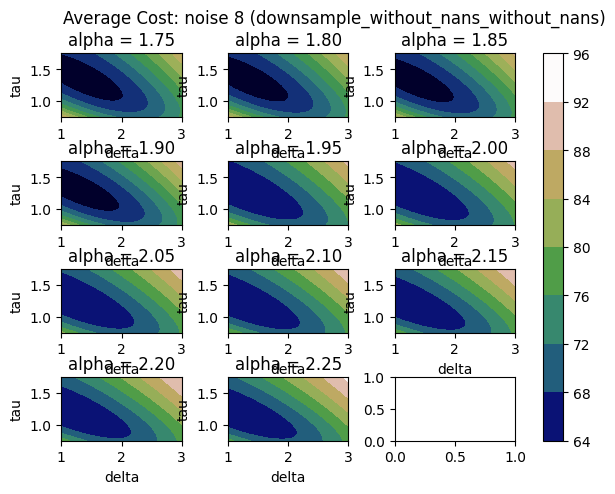

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_without_nans) = 80.49698528944081; at
      delta   tau  alpha
2540   1.25  1.25    2.0


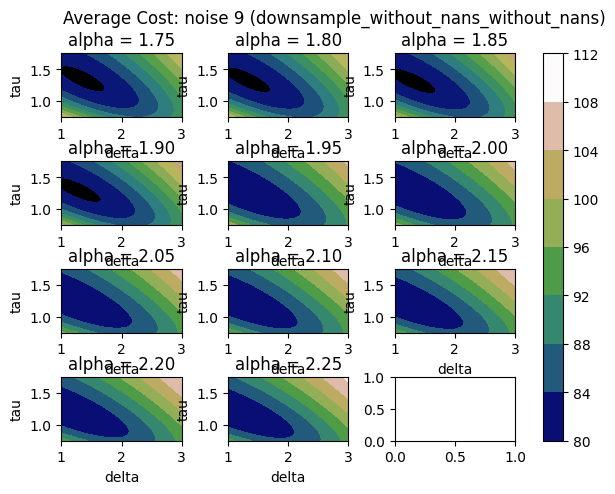

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_without_nans) = 100.60792353588836; at
      delta   tau  alpha
2540   1.25  1.25    2.0


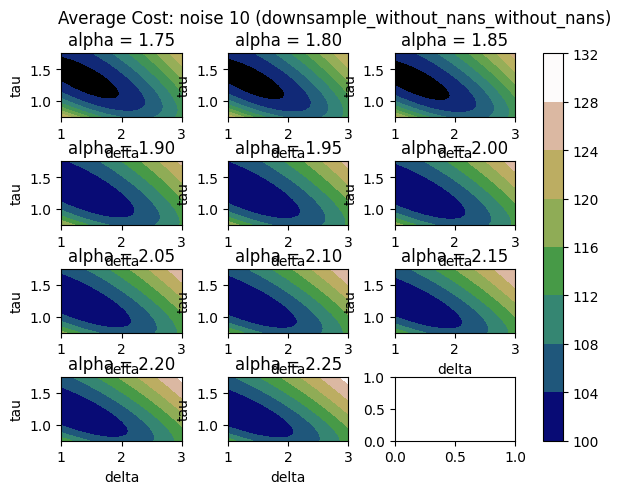

In [30]:
model_name = 'downsample_without_nans_without_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')

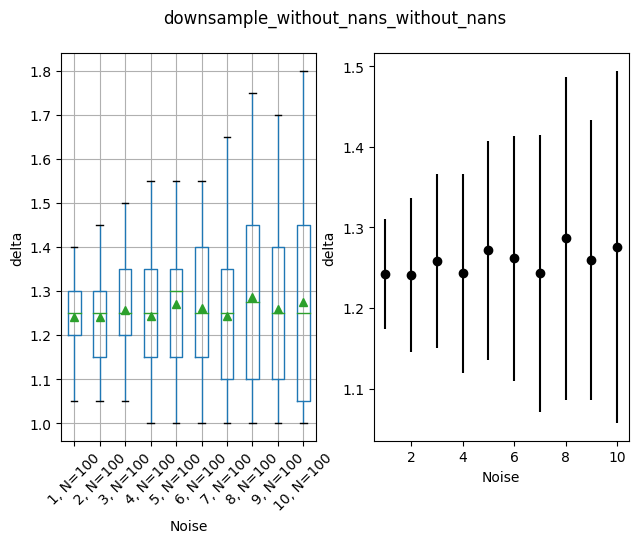

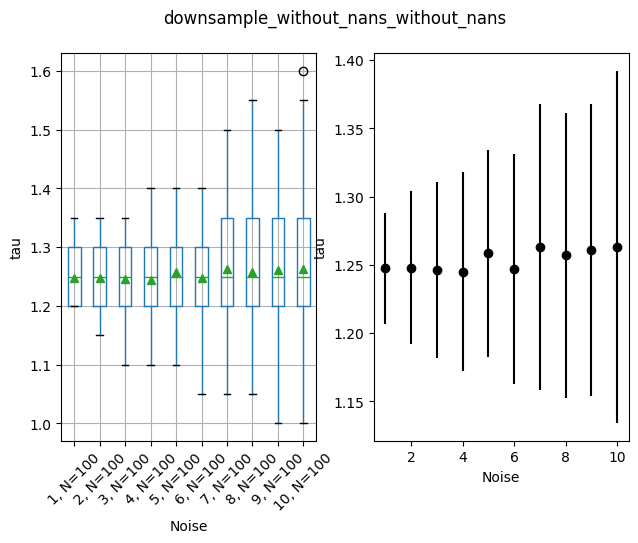

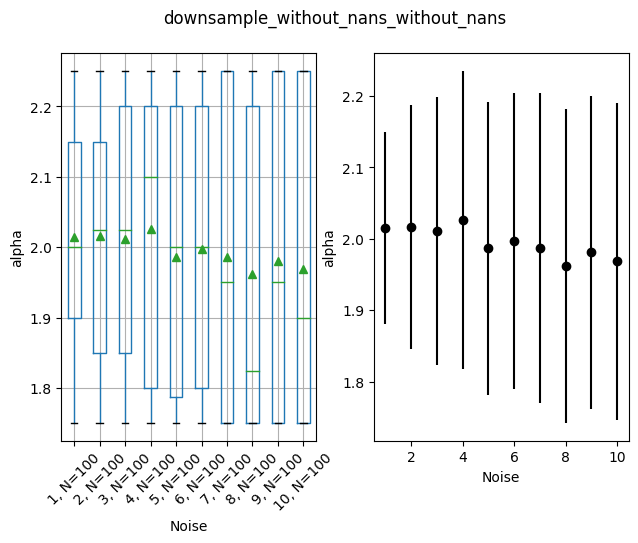

In [31]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

### Downsample with Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_with_nans) = 1.0018737646890852; at
      delta   tau  alpha
2541   1.25  1.25    2.0


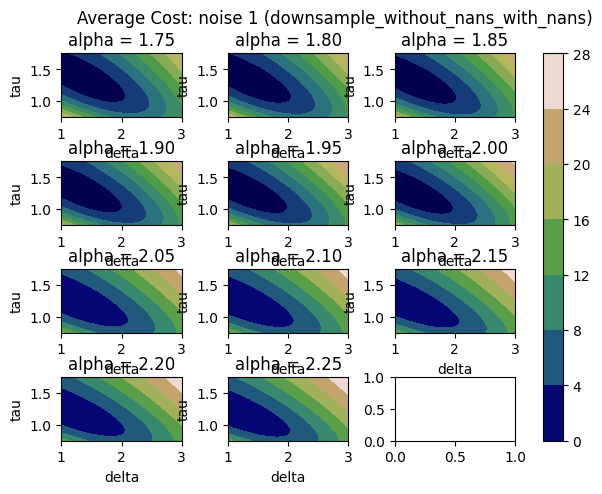

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_with_nans) = 4.00657757463318; at
      delta   tau  alpha
2541   1.25  1.25    2.0


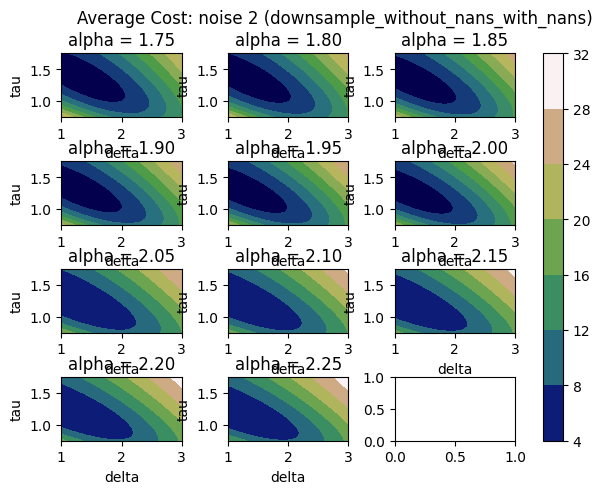

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_with_nans) = 8.93057459594169; at
      delta  tau  alpha
2063    1.2  1.2   2.15


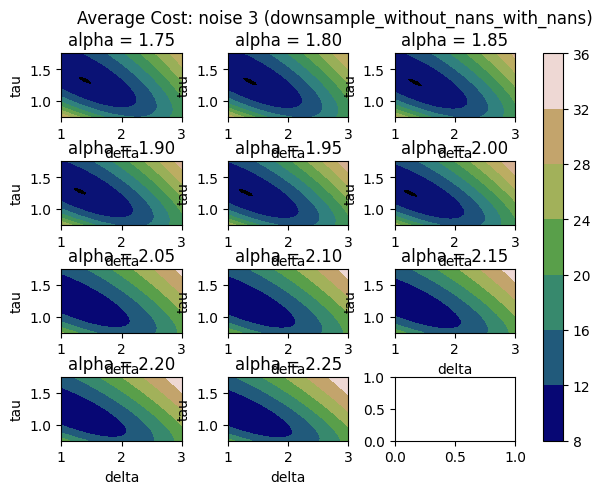

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_with_nans) = 16.007406320459516; at
      delta  tau  alpha
1603   1.15  1.2    2.2


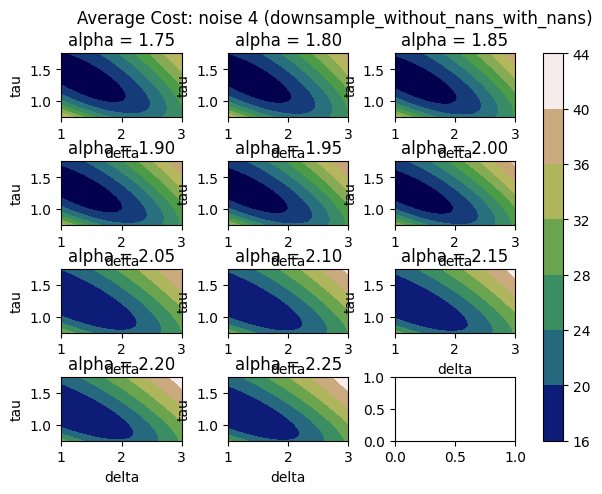

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_with_nans) = 25.225214008536145; at
      delta   tau  alpha
2541   1.25  1.25    2.0


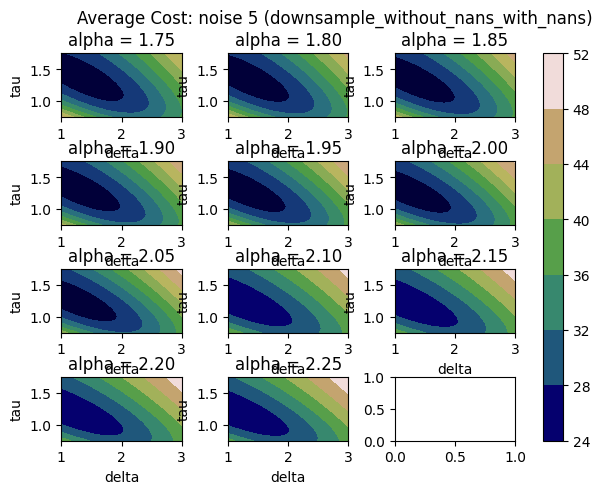

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_with_nans) = 35.97044607448396; at
      delta   tau  alpha
2541   1.25  1.25    2.0


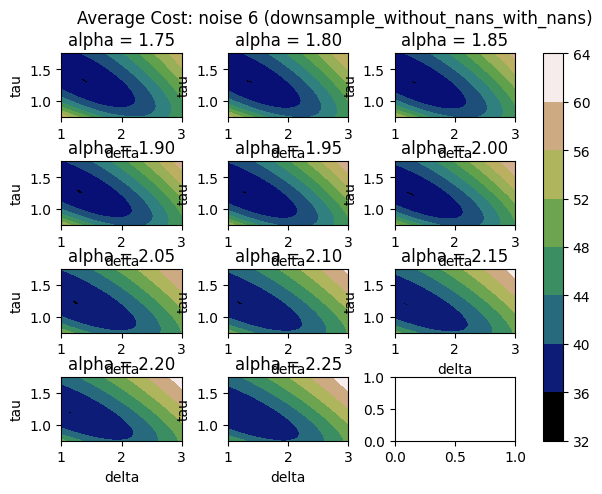

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_with_nans) = 48.94923258854632; at
      delta   tau  alpha
2081    1.2  1.25   2.05


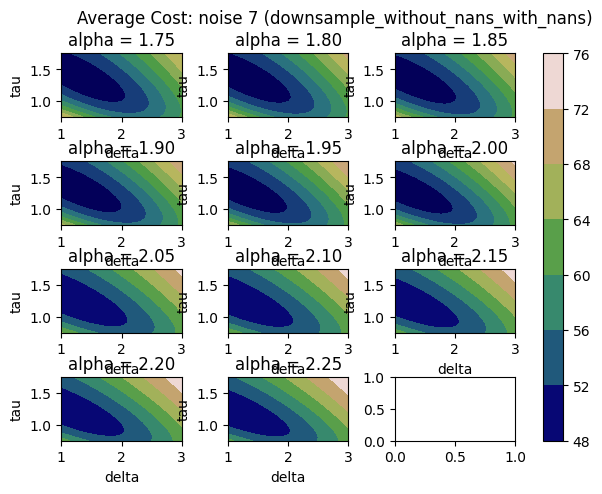

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_with_nans) = 64.14200760870412; at
      delta   tau  alpha
3001    1.3  1.25   1.95


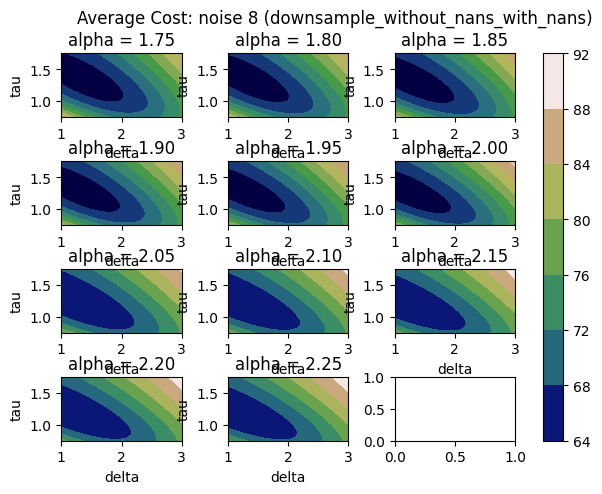

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_with_nans) = 80.33812370345431; at
      delta   tau  alpha
2541   1.25  1.25    2.0


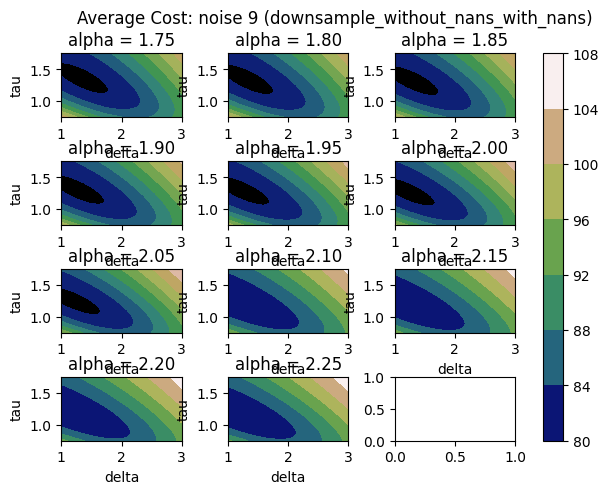

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_with_nans) = 100.40984720579354; at
      delta   tau  alpha
3001    1.3  1.25   1.95


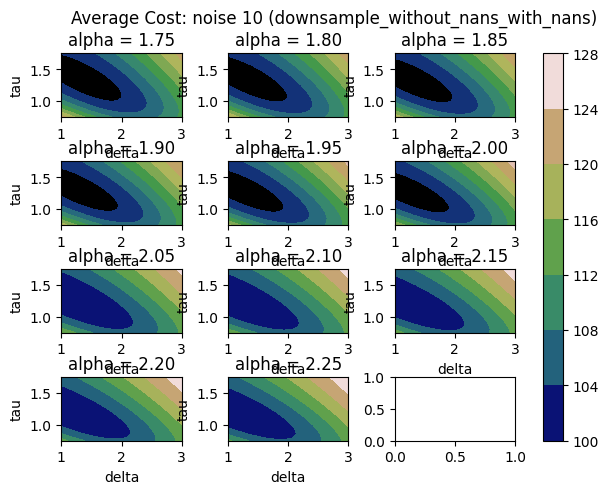

In [32]:
model_name = 'downsample_without_nans_with_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')


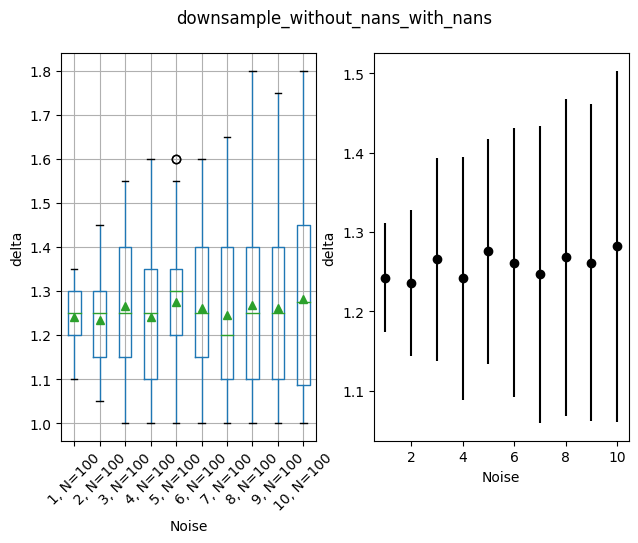

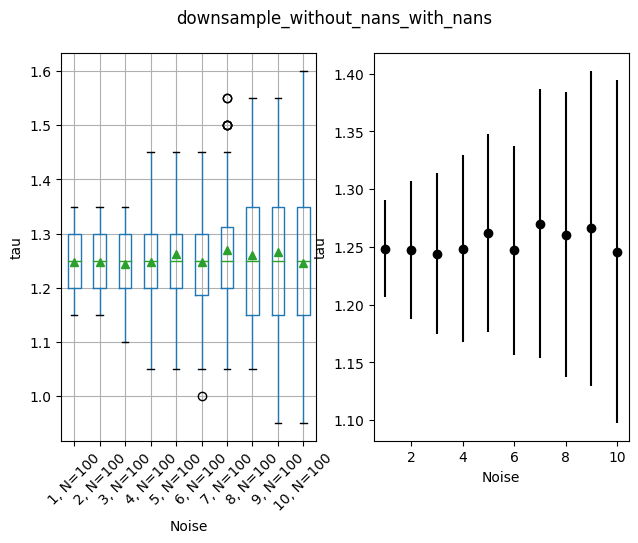

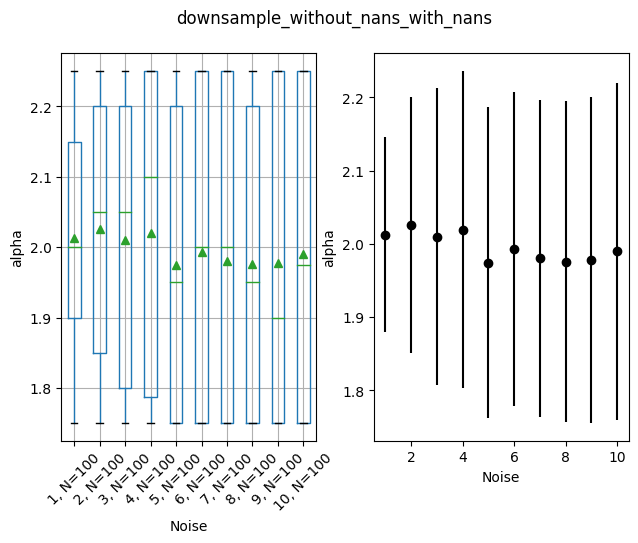

In [33]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

## Local Minima Analysis

### Downsample without missing data

In [34]:
model = df['model_name'].unique()[0]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_without_nans'


In [35]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [36]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1        97    1.001631                1.05  1.2000000000000004   
1         1        21    0.994448                 1.1  1.2000000000000004   
2         1        54    0.995622                 1.1  1.2000000000000004   
3         1        91    0.947015                 1.1  1.2000000000000004   
4         1        12    1.046396                 1.1  1.2000000000000004   
...     ...       ...         ...                 ...                 ...   
2647     10        45  101.631933  1.7000000000000006  1.0500000000000003   
2648     10        36   90.684574  1.7000000000000006  1.2500000000000004   
2649     10        95  109.577921  1.7500000000000007  1.0500000000000003   
2650     10        95  109.575326  1.8000000000000007  1.1000000000000003   
2651     10        36   90.677209  1.8000000000000007  1.3000000000000005   

                   alpha  
0     2.2500000000000004  
1                    2.2  
2                    2.2  
3                    2.2  
4     2.2500000000000004  
...                  ...  
2647                 2.0  
2648  1.9000000000000001  
2649  1.9500000000000002  
2650                 1.8  
2651                1.75  

[2652 rows x 6 columns]

In [37]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  3.31  0.506423  2.0  3.0  3.0  4.0  4.0
2                      100.0  3.29  0.671121  2.0  3.0  3.0  4.0  4.0
3                      100.0  3.22  0.823641  1.0  3.0  3.0  4.0  4.0
4                      100.0  2.75  0.967920  1.0  2.0  3.0  3.0  4.0
5                      100.0  2.70  1.000000  1.0  2.0  3.0  3.0  4.0
6                      100.0  2.69  1.098162  1.0  2.0  3.0  4.0  5.0
7                      100.0  2.33  1.128644  1.0  1.0  2.0  3.0  4.0
8                      100.0  2.08  1.070070  1.0  1.0  2.0  3.0  4.0
9                      100.0  2.17  1.214849  1.0  1.0  2.0  3.0  5.0
10                     100.0  1.98  1.014839  1.0  1.0  2.0  3.0  4.0

#### Local minima at edges

In [38]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

noise iteration        cost delta                 tau  \
660       3        38    8.419785   1.0  1.2000000000000004   
661       3        26    8.738270   1.0  1.2000000000000004   
982       4        95   17.625127   1.0  1.2000000000000004   
983       4        60   16.569983   1.0  1.2500000000000004   
984       4        93   16.307868   1.0  1.2500000000000004   
...     ...       ...         ...   ...                 ...   
2490     10        20   96.816562   1.0  1.4500000000000006   
2491     10        92   96.542791   1.0  1.4500000000000006   
2492     10        57  104.546143   1.0  1.4500000000000006   
2493     10        49  101.742751   1.0  1.4500000000000006   
2494     10        41   94.367510   1.0  1.6000000000000008   

                   alpha  
660                  2.2  
661   2.2500000000000004  
982   2.2500000000000004  
983                  2.2  
984                  2.2  
...                  ...  
2490                1.75  
2491                1.75  
2492                1.85  
2493  1.9000000000000001  
2494                1.75  

[166 rows x 6 columns]

In [39]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [40]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [41]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [42]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
257       1        97    1.017468  1.3000000000000003  1.3500000000000005   
298       1         1    0.910331  1.3500000000000003  1.3500000000000005   
299       1         2    1.022525  1.3500000000000003  1.3500000000000005   
300       1         4    1.017835  1.3500000000000003  1.3500000000000005   
301       1         8    1.012911  1.3500000000000003  1.3500000000000005   
...     ...       ...         ...                 ...                 ...   
2637     10        11   98.026405  1.6000000000000005  1.2000000000000004   
2638     10        76  106.323997  1.6000000000000005  1.2500000000000004   
2642     10        82  101.437286  1.6500000000000006  1.2000000000000004   
2644     10        13   96.572901  1.6500000000000006  1.2500000000000004   
2651     10        36   90.677209  1.8000000000000007  1.3000000000000005   

     alpha  
257   1.75  
298   1.75  
299   1.75  
300   1.75  
301   1.75  
...    ...  
2637  1.75  
2638  1.75  
2642  1.75  
2644  1.75  
2651  1.75  

[408 rows x 6 columns]

In [43]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        29      3  1.3500000000000003   26    29      1  1.3500000000000005   
10       46     15  1.4500000000000004    6    46     11  1.2500000000000004   
2        32      5  1.4000000000000004   15    32      2  1.3500000000000005   
3        41      7  1.4000000000000004   15    41      3  1.3500000000000005   
4        36      8  1.3500000000000003   10    36      4  1.3500000000000005   
5        39      8  1.4000000000000004    9    39      5  1.3500000000000005   
6        45     10  1.4500000000000004    8    45      6  1.3000000000000005   
7        40     12  1.3500000000000003    7    40      8  1.3000000000000005   
8        47     16  1.3500000000000003    6    47      9  1.2500000000000004   
9        53     15  1.4000000000000004    8    53      8  1.4000000000000006   

            
      freq  
noise       
1       29  
10       9  
2       21  
3       25  
4       15  
5       15  
6       14  
7       10  
8       14  
9       13

In [44]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
0         1        97    1.001631                1.05  1.2000000000000004   
4         1        12    1.046396                 1.1  1.2000000000000004   
5         1        16    0.977216                 1.1  1.2000000000000004   
6         1        50    1.000982                 1.1  1.2000000000000004   
7         1        64    0.976594                 1.1  1.2000000000000004   
...     ...       ...         ...                 ...                 ...   
2604     10        18   89.060232  1.4500000000000004  1.1000000000000003   
2627     10        66  109.400383  1.5500000000000005  1.0500000000000003   
2628     10        36   90.718278  1.5500000000000005  1.1500000000000004   
2633     10        45  101.608647  1.6000000000000005  1.0000000000000002   
2646     10         3   93.742775  1.7000000000000006  1.0000000000000002   

                   alpha  
0     2.2500000000000004  
4     2.2500000000000004  
5     2.2500000000000004  
6     2.2500000000000004  
7     2.2500000000000004  
...                  ...  
2604  2.2500000000000004  
2627  2.2500000000000004  
2628  2.2500000000000004  
2633  2.2500000000000004  
2646  2.2500000000000004  

[359 rows x 6 columns]

In [45]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1         9      4                 1.1    4     9      2  1.2000000000000004   
10       37     12                 1.0   10    37      7  1.1500000000000004   
2        42      4                 1.1   15    42      2  1.2000000000000004   
3        50      8  1.2000000000000002   17    50      3  1.2000000000000004   
4        40      7  1.1500000000000001   12    40      4  1.1500000000000004   
5        39      8  1.1500000000000001   10    39      4  1.1500000000000004   
6        37      9  1.1500000000000001   10    37      5  1.2000000000000004   
7        37     10                 1.0    7    37      6  1.2000000000000004   
8        32     11                 1.1    9    32      6  1.2000000000000004   
9        36     11                 1.0    9    36      8  1.2500000000000004   

            
      freq  
noise       
1        5  
10       9  
2       21  
3       24  
4       20  
5       19  
6       13  
7       12  
8       11  
9        9

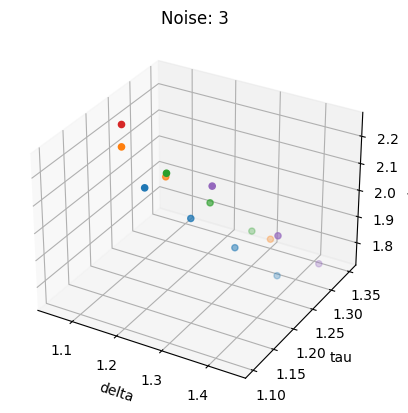

In [46]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

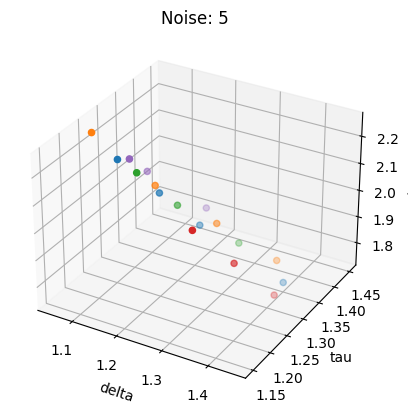

In [47]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

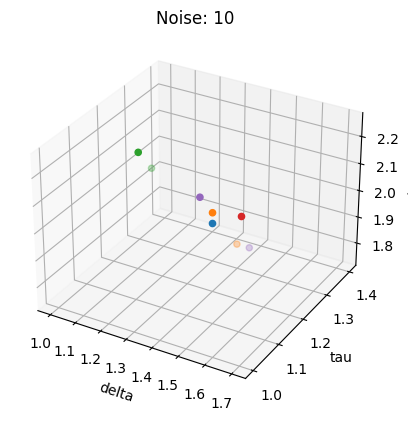

In [48]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

### Downsample with missing data

In [49]:
model = df['model_name'].unique()[1]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_with_nans'


In [50]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [51]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1        97    0.964725                1.05  1.2000000000000004   
1         1         3    0.922715                 1.1  1.2000000000000004   
2         1        21    0.997128                 1.1  1.2000000000000004   
3         1        82    1.054909                 1.1  1.2000000000000004   
4         1         4    0.975208                 1.1  1.2000000000000004   
...     ...       ...         ...                 ...                 ...   
2531     10        62   97.966347  1.7500000000000007  1.0500000000000003   
2532     10        82  103.297398  1.7500000000000007  1.1000000000000003   
2533     10         3   94.484759  1.8000000000000007  1.0500000000000003   
2534     10        95  110.384517  1.8000000000000007  1.1000000000000003   
2535     10         3   94.508592  1.9000000000000008  1.1000000000000003   

                   alpha  
0     2.2500000000000004  
1                    2.2  
2                    2.2  
3                    2.2  
4     2.2500000000000004  
...                  ...  
2531                1.75  
2532                1.75  
2533                 2.0  
2534                1.75  
2535                 1.8  

[2536 rows x 6 columns]

In [52]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  3.39  0.529818  2.0  3.0  3.0  4.0  4.0
2                      100.0  3.29  0.769297  1.0  3.0  3.0  4.0  4.0
3                      100.0  2.96  0.963160  1.0  2.0  3.0  4.0  4.0
4                      100.0  2.69  1.070212  1.0  2.0  3.0  4.0  4.0
5                      100.0  2.66  1.130120  1.0  2.0  3.0  4.0  4.0
6                      100.0  2.53  1.067944  1.0  2.0  3.0  3.0  4.0
7                      100.0  2.01  1.058825  1.0  1.0  2.0  3.0  4.0
8                      100.0  1.91  1.045384  1.0  1.0  2.0  3.0  5.0
9                      100.0  1.96  1.091010  1.0  1.0  2.0  3.0  4.0
10                     100.0  1.96  1.043692  1.0  1.0  2.0  3.0  4.0

#### Local minima at edges

In [53]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

noise iteration        cost delta                 tau  \
668       3        38    8.304353   1.0  1.2000000000000004   
669       3        96    8.586935   1.0  1.2000000000000004   
670       3        36    8.599004   1.0  1.2500000000000004   
671       3        89    7.903973   1.0  1.2500000000000004   
964       4        83   16.876586   1.0  1.1500000000000004   
...     ...       ...         ...   ...                 ...   
2371     10        55   99.327423   1.0  1.4500000000000006   
2372     10        84   93.582421   1.0  1.4500000000000006   
2373     10        33  104.631349   1.0  1.4500000000000006   
2374     10        33  104.630085   1.0  1.5000000000000007   
2375     10        41   92.839072   1.0  1.6000000000000008   

                   alpha  
668                  2.2  
669   2.2500000000000004  
670                  2.2  
671   2.2500000000000004  
964   2.2500000000000004  
...                  ...  
2371                1.75  
2372                1.75  
2373  1.9000000000000001  
2374                 1.8  
2375                1.75  

[190 rows x 6 columns]

In [54]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [55]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [56]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [57]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
261       1        21    0.993143  1.3000000000000003  1.3500000000000005   
262       1        97    0.973139  1.3000000000000003  1.3500000000000005   
309       1         4    0.996627  1.3500000000000003  1.3500000000000005   
310       1         8    0.973124  1.3500000000000003  1.3500000000000005   
311       1        11    0.968367  1.3500000000000003  1.3500000000000005   
...     ...       ...         ...                 ...                 ...   
2527     10        81  102.584026  1.6500000000000006  1.2000000000000004   
2528     10        77  105.800604  1.6500000000000006  1.3000000000000005   
2531     10        62   97.966347  1.7500000000000007  1.0500000000000003   
2532     10        82  103.297398  1.7500000000000007  1.1000000000000003   
2534     10        95  110.384517  1.8000000000000007  1.1000000000000003   

     alpha  
261   1.75  
262   1.75  
309   1.75  
310   1.75  
311   1.75  
...    ...  
2527  1.75  
2528  1.75  
2531  1.75  
2532  1.75  
2534  1.75  

[398 rows x 6 columns]

In [58]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        31      4  1.3500000000000003   27    31      2  1.3500000000000005   
10       49     15                 1.0    7    49     12  1.4000000000000006   
2        34      4  1.3500000000000003   16    34      2  1.3500000000000005   
3        31      5  1.4000000000000004   14    31      3  1.3500000000000005   
4        35      6  1.4000000000000004    9    35      6  1.3500000000000005   
5        42     11  1.4000000000000004    8    42      5  1.3000000000000005   
6        41     12  1.5000000000000004    6    41      7  1.3000000000000005   
7        42     13  1.3000000000000003    6    42      9  1.4500000000000006   
8        49     14  1.5500000000000005    7    49      9  1.3000000000000005   
9        44     16  1.4000000000000004    6    44      9  1.3000000000000005   

            
      freq  
noise       
1       30  
10      13  
2       27  
3       17  
4       16  
5       15  
6       11  
7       10  
8       11  
9        9

In [59]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
0         1        97    0.964725                1.05  1.2000000000000004   
4         1         4    0.975208                 1.1  1.2000000000000004   
5         1        11    0.955911                 1.1  1.2000000000000004   
6         1        12    0.985919                 1.1  1.2000000000000004   
7         1        16    0.964882                 1.1  1.2000000000000004   
...     ...       ...         ...                 ...                 ...   
2493     10        89   93.732506  1.5000000000000004  0.9500000000000002   
2495     10        45   99.943569  1.5000000000000004  1.0000000000000002   
2507     10        66  110.604454  1.5500000000000005  1.0500000000000003   
2514     10        82  103.292663  1.6000000000000005  0.9500000000000002   
2529     10         3   94.460849  1.7000000000000006  1.0000000000000002   

                   alpha  
0     2.2500000000000004  
4     2.2500000000000004  
5     2.2500000000000004  
6     2.2500000000000004  
7     2.2500000000000004  
...                  ...  
2493  2.2500000000000004  
2495  2.2500000000000004  
2507  2.2500000000000004  
2514  2.2500000000000004  
2529  2.2500000000000004  

[400 rows x 6 columns]

In [60]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        22      4                 1.1   11    22      2  1.2000000000000004   
10       45     14                 1.0    8    45      9  1.1500000000000004   
2        42      4                 1.1   15    42      2  1.2000000000000004   
3        41      7                 1.1   13    41      4  1.1500000000000004   
4        49      8  1.1500000000000001   14    49      5  1.2000000000000004   
5        46      9  1.1500000000000001    9    46      5  1.1500000000000004   
6        48      9                 1.0   11    48      6  1.1500000000000004   
7        37     10                 1.0    8    37      5  1.2000000000000004   
8        29      9  1.2000000000000002    5    29      5  1.2000000000000004   
9        41     13                 1.0    6    41      8  1.1500000000000004   

            
      freq  
noise       
1       13  
10       9  
2       22  
3       18  
4       23  
5       19  
6       16  
7       11  
8       10  
9       11

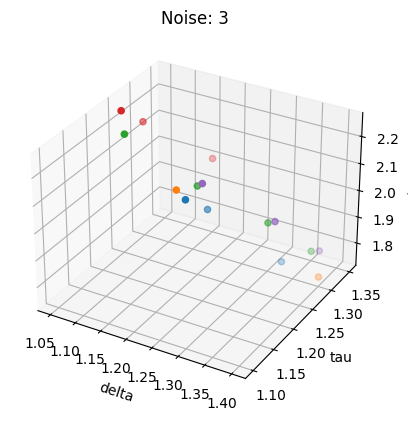

In [61]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

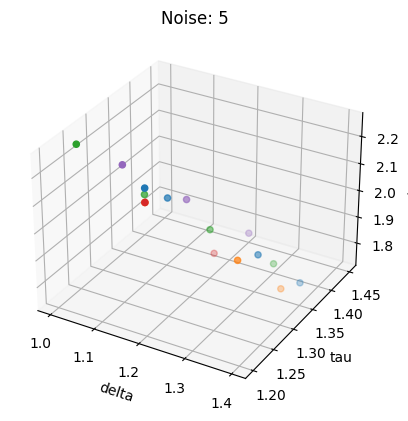

In [62]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

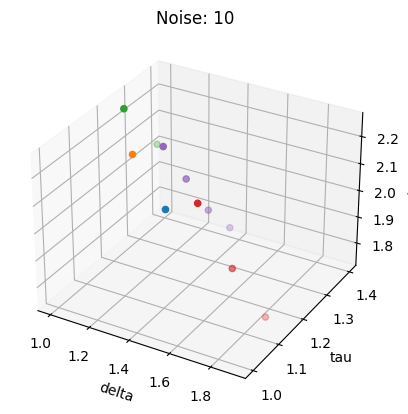

In [63]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()